## **Import Libraries**

In [37]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.utils.data import random_split
from torch import optim
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Load Dataset**

In [39]:
# Transform is defined to preprocess the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the train set
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)

# Load the test set
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

n_valid = int(0.1 * len(train_dataset))
n_train = len(train_dataset) - n_valid
#split into validation dataset
train_dataset, val_dataset = random_split(train_dataset, [n_train, n_valid])

# Load batches using dataloader
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## **Convolutional Neural Network**

## Note:
Dropout serves as a regularization technique for neural networks. It addresses the risk of neurons within a layer being overly dependent on specific neurons from the preceding layer during training, potentially leading to overfitting. To mitigate this, Dropout introduces a regularization mechanism by randomly deactivating connections, or "dropping" them, between neurons in consecutive layers during the training process.

In [40]:
class convolutionalNN(nn.Module):
  def __init__(self):
    super(convolutionalNN, self).__init__()

    # convolution layer 1
    self.convolution = nn.Sequential(
        nn.Conv2d(in_channels=3 , out_channels=32, kernel_size = 5, stride=1, padding=2),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(2),
    )
    # dropout layer
    self.dropout = nn.Dropout(p=0.5)

    # defining the linear layer
    self.linear = nn.Linear(32*2*2, 10)

  def forward(self, x):
    x = self.convolution(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    out = self.linear(x)
    out = F.softmax(out, dim=1) # applying softmax to output layer

    return out

In [41]:
model = convolutionalNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

## **Training and Testing**

In [42]:
def train(num_epochs, model, train_loader, val_loader, criterion, optimizer, model_filename='model.pth'):
    train_losses = [] # store train losses per epoch
    val_losses = [] # store validation losses per epoch

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()   # Zero the gradients to avoid accumulation

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels) # Calculate the loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()   # Update the model's parameters

            running_loss += loss.item()

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val = inputs_val.to(device)
                labels_val = labels_val.to(device)

                outputs_val = model(inputs_val)   # Forward pass on validation data
                loss_val = criterion(outputs_val, labels_val)
                val_loss += loss_val.item()

        epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        # Save the model at the end of each epoch
        torch.save(model.state_dict(), model_filename)

        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

num_epochs = 8
train_losses, val_losses = train(num_epochs, model, train_loader, val_loader, criterion, optimizer)


Epoch 1/8, Train Loss: 2.2873
Epoch 1/8, Validation Loss: 2.2475
Epoch 2/8, Train Loss: 2.2394
Epoch 2/8, Validation Loss: 2.2077
Epoch 3/8, Train Loss: 2.2154
Epoch 3/8, Validation Loss: 2.1871
Epoch 4/8, Train Loss: 2.2014
Epoch 4/8, Validation Loss: 2.1841
Epoch 5/8, Train Loss: 2.1944
Epoch 5/8, Validation Loss: 2.1758
Epoch 6/8, Train Loss: 2.1853
Epoch 6/8, Validation Loss: 2.1707
Epoch 7/8, Train Loss: 2.1820
Epoch 7/8, Validation Loss: 2.1624
Epoch 8/8, Train Loss: 2.1781
Epoch 8/8, Validation Loss: 2.1621


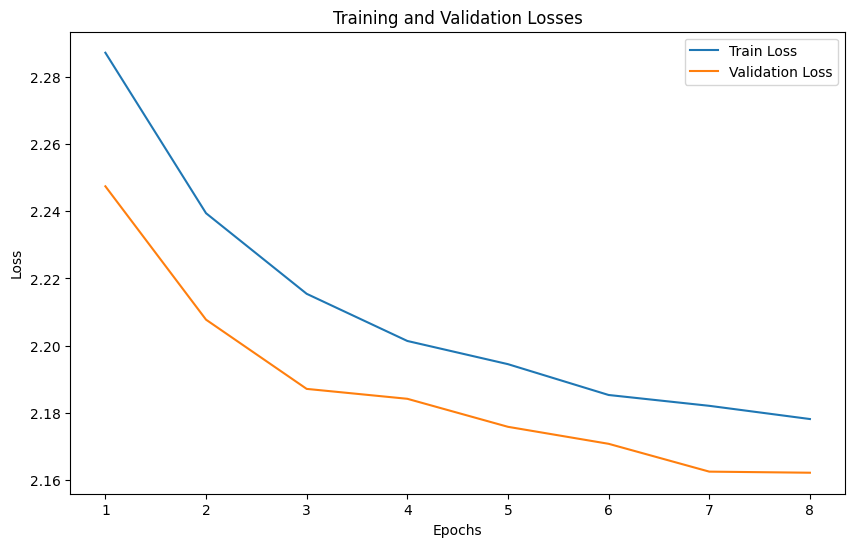

In [43]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

## **Model Evaluation**

In [44]:
# Evaluate model
def evaluate_model(model, test_loader):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to count correct predictions and total examples
    correct = 0
    total = 0

    # Lists to store predicted and true labels for further analysis
    preds = []
    true_labels = []

    with torch.no_grad():
        # Loop through batches in the test_loader
        for inputs, batch in test_loader:
            # Move input data and labels to device (CPU or GPU)
            inputs = inputs.to(device)
            batch = batch.to(device)

            # Forward pass to obtain model predictions
            outputs = model(inputs)

            # Get the index of the maximum predicted value (class)
            _, predicted = torch.max(outputs.data, 1)

            # Update total count
            total += batch.size(0)

            # Count correct predictions
            correct += (predicted == batch).sum().item()

            # Extend lists with predicted and true labels
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(batch.cpu().numpy())

    # Calculate accuracy by dividing correct predictions by total examples
    accuracy = correct / total

    # Return accuracy and lists of predicted and true labels
    return accuracy, np.array(preds), np.array(true_labels)


## **T-Sne Plot**

In [45]:
# t-SNE plot
def tsne(test_pred, isinstance):
    # Create a t-SNE object with specified parameters
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)

    # Reshape the predicted values for compatibility with t-SNE
    test_pred = test_pred.reshape(-1, 1)

    # Apply t-SNE to obtain the embedded 2D representation
    X_embedded = tsne.fit_transform(test_pred)

    # Plot the t-SNE result
    plt.figure(figsize=(10, 8))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=test_labels, cmap='viridis')
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(f"t-SNE Plot on adding {isinstance+1} hidden layer")  # Corrected variable name 'i' to 'isinstance'
    plt.show()


## **Greedy Layer-Wise Training**


Adding 1 hidden layer

Epoch 1/8, Train Loss: 2.1737
Epoch 1/8, Validation Loss: 2.1567
Epoch 2/8, Train Loss: 2.1707
Epoch 2/8, Validation Loss: 2.1578
Epoch 3/8, Train Loss: 2.1716
Epoch 3/8, Validation Loss: 2.1591
Epoch 4/8, Train Loss: 2.1625
Epoch 4/8, Validation Loss: 2.1567
Epoch 5/8, Train Loss: 2.1682
Epoch 5/8, Validation Loss: 2.1568
Epoch 6/8, Train Loss: 2.1655
Epoch 6/8, Validation Loss: 2.1557
Epoch 7/8, Train Loss: 2.1593
Epoch 7/8, Validation Loss: 2.1533
Epoch 8/8, Train Loss: 2.1685
Epoch 8/8, Validation Loss: 2.1537


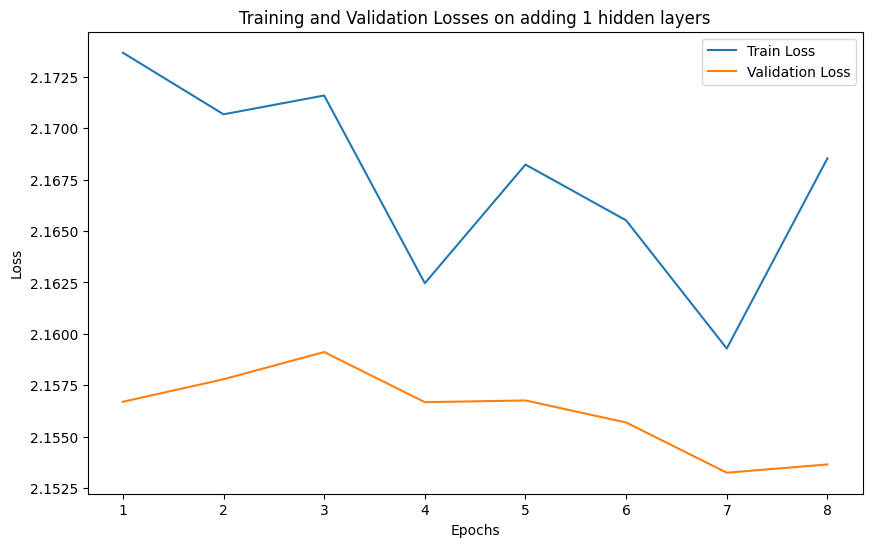


Test results on adding 1 hidden layers

Test Accuracy: 30.525%

Confusion Matrix on adding 1 hidden layers



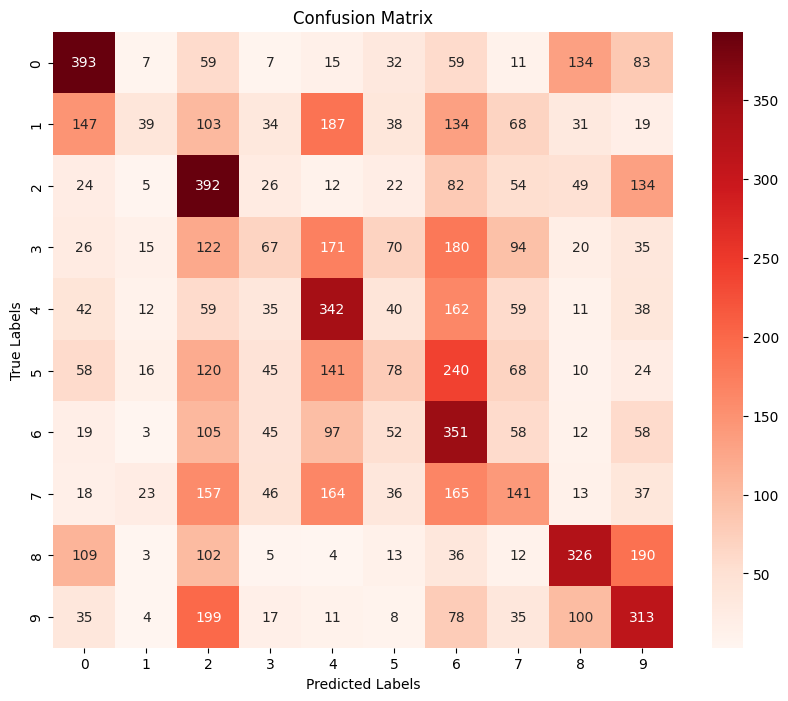


T-Sne plot on adding 1 hidden layer



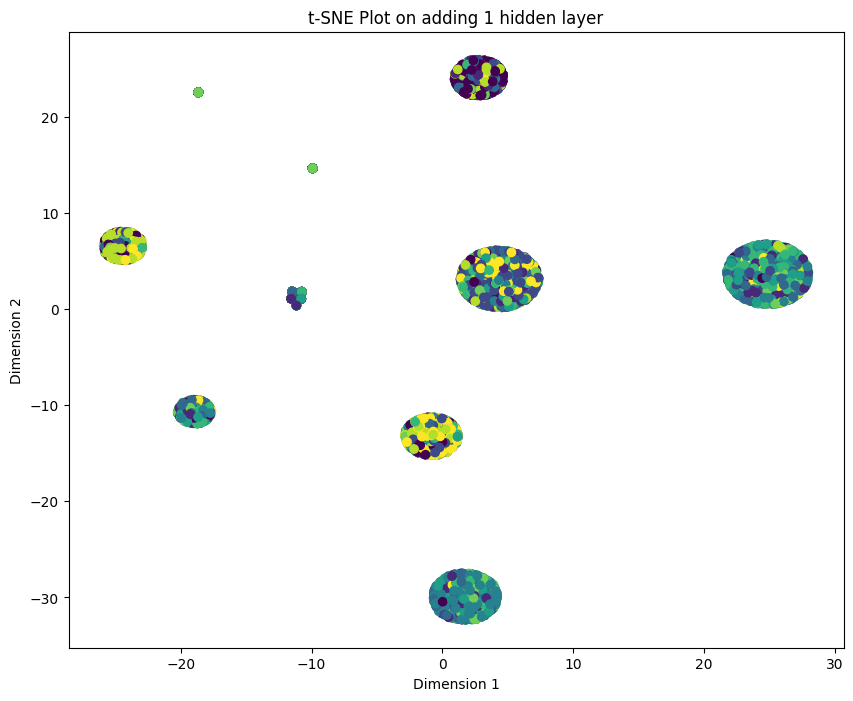


Adding 2 hidden layer

Epoch 1/8, Train Loss: 2.1607
Epoch 1/8, Validation Loss: 2.1550
Epoch 2/8, Train Loss: 2.1631
Epoch 2/8, Validation Loss: 2.1554
Epoch 3/8, Train Loss: 2.1576
Epoch 3/8, Validation Loss: 2.1571
Epoch 4/8, Train Loss: 2.1604
Epoch 4/8, Validation Loss: 2.1552
Epoch 5/8, Train Loss: 2.1615
Epoch 5/8, Validation Loss: 2.1511
Epoch 6/8, Train Loss: 2.1586
Epoch 6/8, Validation Loss: 2.1520
Epoch 7/8, Train Loss: 2.1577
Epoch 7/8, Validation Loss: 2.1510
Epoch 8/8, Train Loss: 2.1585
Epoch 8/8, Validation Loss: 2.1493


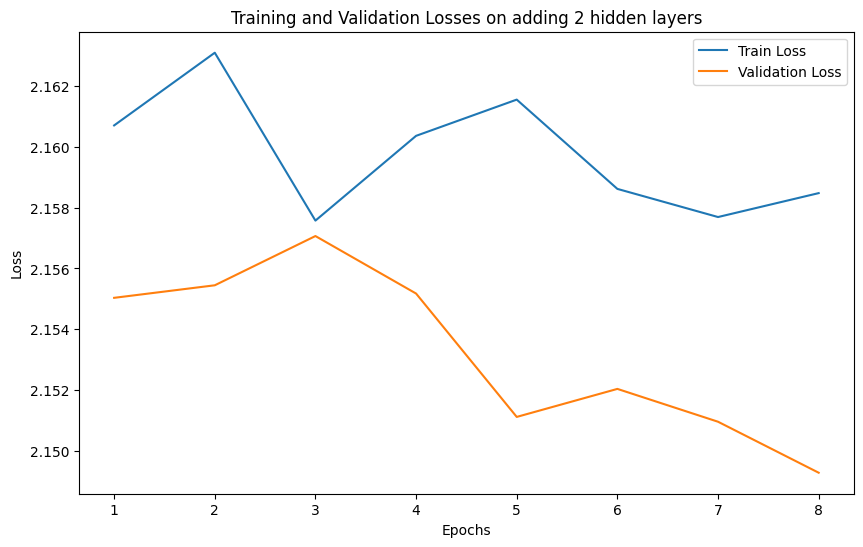


Test results on adding 2 hidden layers

Test Accuracy: 30.700%

Confusion Matrix on adding 2 hidden layers



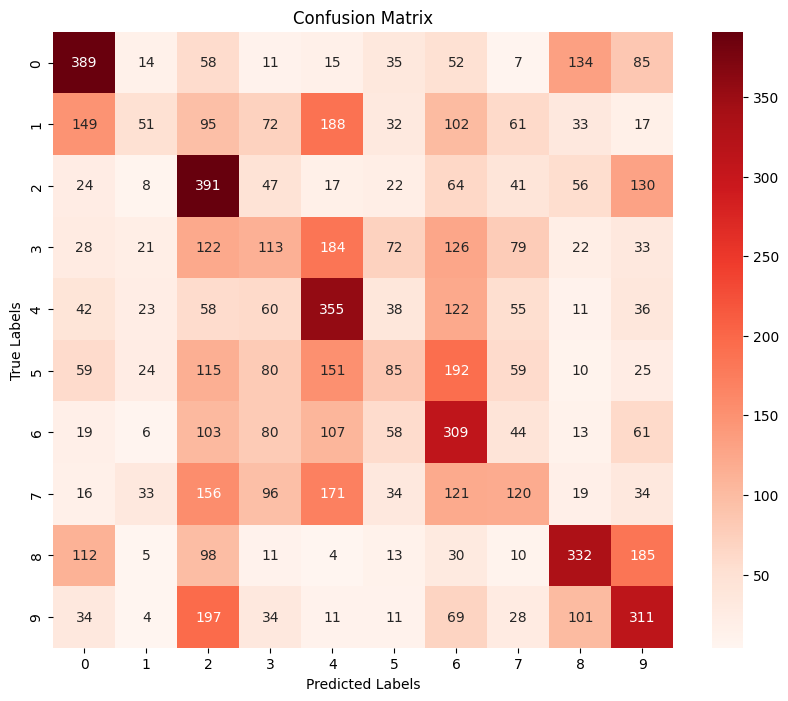


T-Sne plot on adding 2 hidden layer



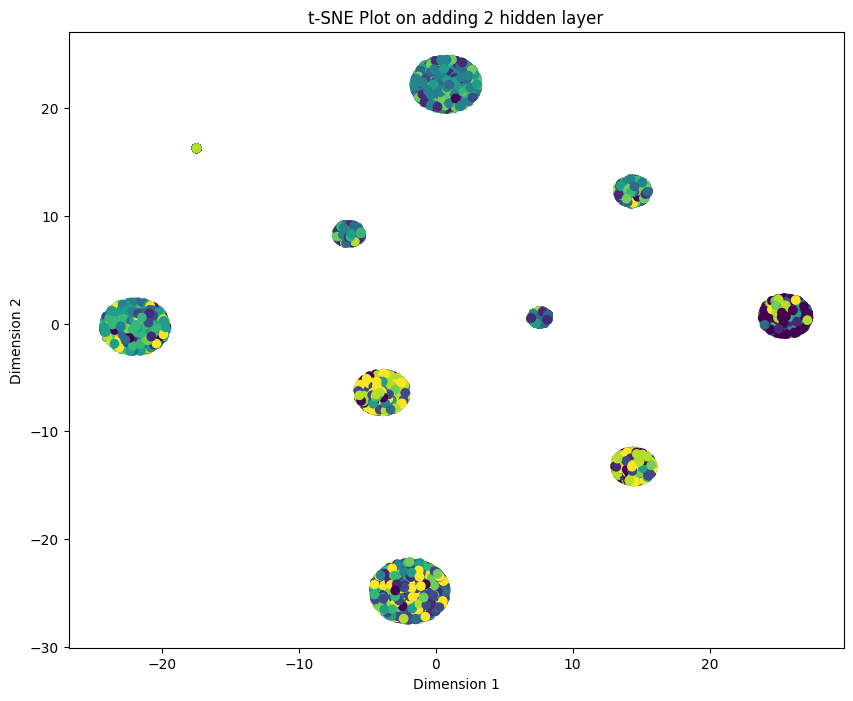


Adding 3 hidden layer

Epoch 1/8, Train Loss: 2.1562
Epoch 1/8, Validation Loss: 2.1527
Epoch 2/8, Train Loss: 2.1592
Epoch 2/8, Validation Loss: 2.1507
Epoch 3/8, Train Loss: 2.1566
Epoch 3/8, Validation Loss: 2.1519
Epoch 4/8, Train Loss: 2.1558
Epoch 4/8, Validation Loss: 2.1516
Epoch 5/8, Train Loss: 2.1567
Epoch 5/8, Validation Loss: 2.1509
Epoch 6/8, Train Loss: 2.1547
Epoch 6/8, Validation Loss: 2.1536
Epoch 7/8, Train Loss: 2.1549
Epoch 7/8, Validation Loss: 2.1514
Epoch 8/8, Train Loss: 2.1550
Epoch 8/8, Validation Loss: 2.1513


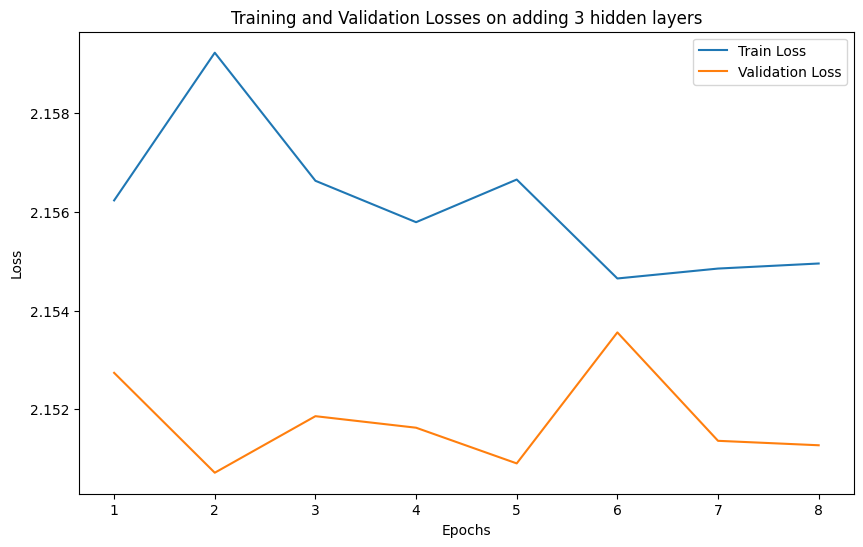


Test results on adding 3 hidden layers

Test Accuracy: 30.600%

Confusion Matrix on adding 3 hidden layers



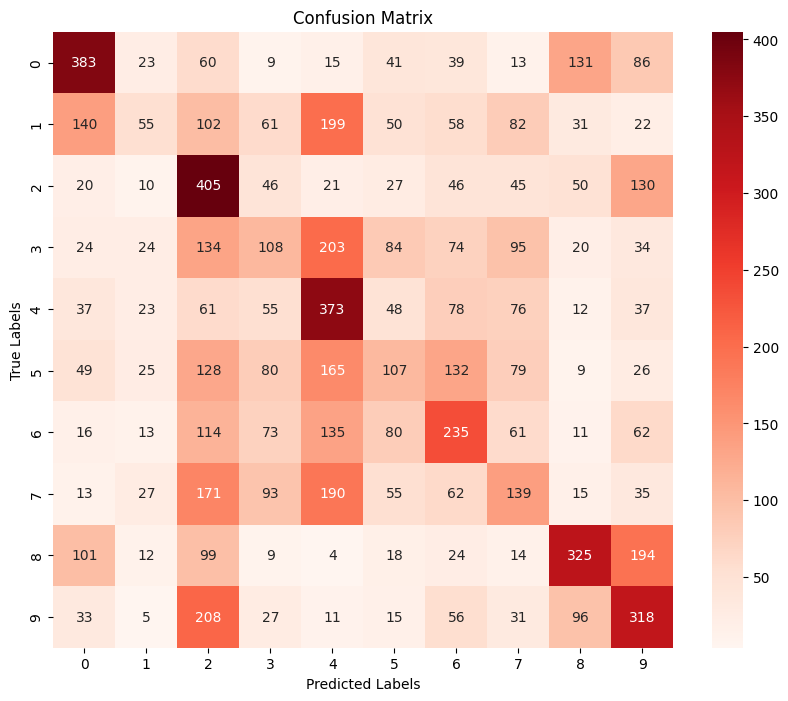


T-Sne plot on adding 3 hidden layer



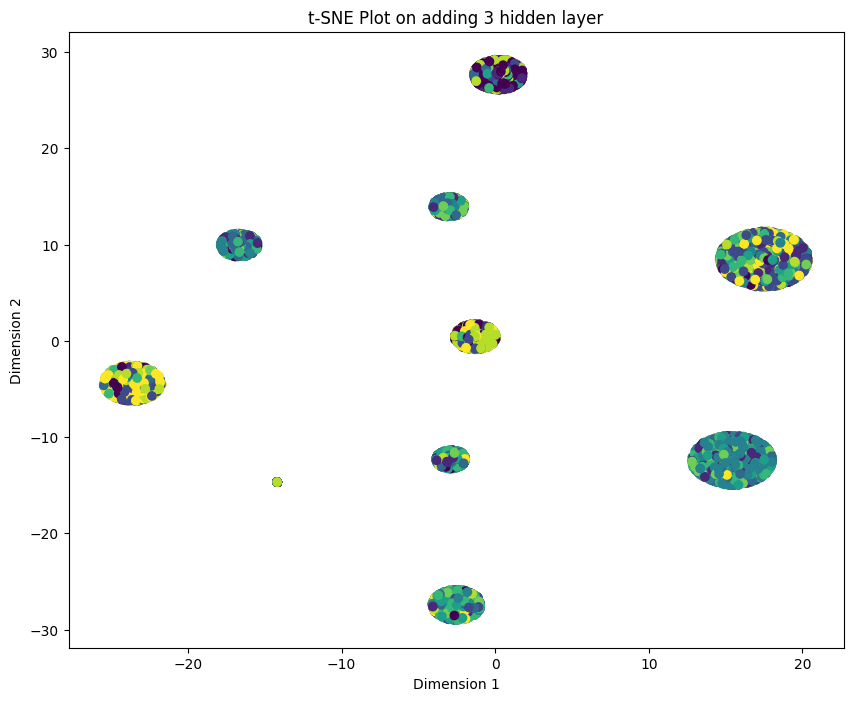

In [46]:
# Greedy layer-wise training
for i in range(3):

    # Remove the output layer
    output_layer = model.linear
    model.linear = nn.Identity()

    # Adding a new hidden layer in the model
    hidden_layer = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(2)
    )

    model.add_module(f'hidden_layer{i + 1}', hidden_layer)
    model.add_module('linear', output_layer)

    # Freeze the weights layers present in the convolutional neural network
    for p in model.convolution.parameters():
        p.requires_grad = False
    for j in range(i + 1):
        for p in getattr(model, f'hidden_layer{j + 1}').parameters():
            p.requires_grad = True  # here we set the param to true for the new layers

    # Training the updated model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print()
    print(f'Adding {i+1} hidden layer')
    print()

    num_epochs = 8
    train_losses, val_losses = train(num_epochs, model, train_loader, val_loader, criterion, optimizer)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Losses on adding {i+1} hidden layers')
    plt.legend()
    plt.show()

    print()
    print(f'Test results on adding {i+1} hidden layers')
    print()

    test_accuracy, test_pred, test_labels = evaluate_model(model, test_loader)
    print(f'Test Accuracy: {test_accuracy*100:.3f}%')

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(test_labels, test_pred)

    print()
    print(f'Confusion Matrix on adding {i+1} hidden layers')
    print()
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    #plot tsne
    print()
    print(f'T-Sne plot on adding {i+1} hidden layer')
    print()
    tsne(test_pred, i)